In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import h5py
import numpy as np

h5_path = "/content/drive/MyDrive/Codigos_Fallos/Carpeta_Dataset/dataset_sync.h5"

X_vib, X_acoustic, y = [], [], []

with h5py.File(h5_path, "r") as f:
    for cond in f.keys():
        g = f[cond]
        try:
            # Vibración
            v1 = g["vibration"]["accel_1"]["signal_sync"][:].astype(np.float32)
            v2 = g["vibration"]["accel_2"]["signal_sync"][:].astype(np.float32)
            if len(v1) == 0 or len(v2) == 0:
                continue
            min_len_vib = min(len(v1), len(v2))
            vib = np.stack([v1[:min_len_vib], v2[:min_len_vib]], axis=0)  # (2, L)

            # Acústico
            if "acoustic" in g:
                a = g["acoustic"]["signal_sync"][:].astype(np.float32)
                if len(a) == 0:
                    a = np.zeros(min_len_vib, dtype=np.float32)
            else:
                a = np.zeros(min_len_vib, dtype=np.float32)

            # Longitud mínima por grupo
            min_len_group = min(min_len_vib, len(a))
            vib = vib[:, :min_len_group]
            a = a[:min_len_group]

            # Guardar
            X_vib.append(vib)
            X_acoustic.append(a)
            y.append(cond)

        except Exception as e:
            print(f"Saltando {cond} por error: {e}")

# =====================
# Recorte global (todas las muestras al mismo largo)
# =====================
min_len_all = min(
    min(x.shape[1] for x in X_vib),
    min(len(a) for a in X_acoustic)
)

X_vib = np.array([x[:, :min_len_all] for x in X_vib])
X_acoustic = np.array([a[:min_len_all] for a in X_acoustic])
y = np.array(y)

print("Shapes después de recorte global:")
print("Vib:", X_vib.shape)       # (N, 2, L)
print("Acoustic:", X_acoustic.shape)  # (N, L)
print("y:", y.shape)


Shapes después de recorte global:
Vib: (45, 2, 1536000)
Acoustic: (45, 1536000)
y: (45,)


In [ ]:
# Crear mapping de clases
unique_labels = sorted(set(y))
label_map = {name: idx for idx, name in enumerate(unique_labels)}
y_idx = np.array([label_map[name] for name in y])

num_classes = len(unique_labels)
print("Número de clases:", num_classes)

# Acústico a (N,1,L) para concatenar
X_acoustic = X_acoustic[:, np.newaxis, :]   # (N,1,L)

# Concatenar vib (2,L) + ac (1,L) → (3,L)
X_all = np.concatenate([X_vib, X_acoustic], axis=1)  # (N,3,L)

# =====================
# Normalización (z-score por canal, usando todo el dataset)
# =====================
mean = X_all.mean(axis=(0,2), keepdims=True)   # (1,3,1)
std  = X_all.std(axis=(0,2), keepdims=True) + 1e-8
X_all = (X_all - mean) / std

print("Dataset normalizado:", X_all.shape)


Número de clases: 45
Dataset normalizado: (45, 3, 1536000)


In [ ]:
print("Número de clases detectadas:", num_classes)
print("\nLista completa de clases:")

for idx, name in enumerate(unique_labels):
    print(f"{idx:02d}: {name}")


Número de clases detectadas: 45

Lista completa de clases:
00: 0Nm_BPFI_03
01: 0Nm_BPFI_10
02: 0Nm_BPFI_30
03: 0Nm_BPFO_03
04: 0Nm_BPFO_10
05: 0Nm_BPFO_30
06: 0Nm_Misalign_01
07: 0Nm_Misalign_03
08: 0Nm_Misalign_05
09: 0Nm_Normal
10: 0Nm_Unbalance_0583mg
11: 0Nm_Unbalance_1169mg
12: 0Nm_Unbalance_1751mg
13: 0Nm_Unbalance_2239mg
14: 0Nm_Unbalance_3318mg
15: 2Nm_BPFI_03
16: 2Nm_BPFI_10
17: 2Nm_BPFI_30
18: 2Nm_BPFO_03
19: 2Nm_BPFO_10
20: 2Nm_BPFO_30
21: 2Nm_Misalign_01
22: 2Nm_Misalign_03
23: 2Nm_Misalign_05
24: 2Nm_Normal
25: 2Nm_Unbalance_0583mg
26: 2Nm_Unbalance_1169mg
27: 2Nm_Unbalance_1751mg
28: 2Nm_Unbalance_2239mg
29: 2Nm_Unbalance_3318mg
30: 4Nm_BPFI_03
31: 4Nm_BPFI_10
32: 4Nm_BPFI_30
33: 4Nm_BPFO_03
34: 4Nm_BPFO_10
35: 4Nm_BPFO_30
36: 4Nm_Misalign_01
37: 4Nm_Misalign_03
38: 4Nm_Misalign_05
39: 4Nm_Normal
40: 4Nm_Unbalance_0583mg
41: 4Nm_Unbalance_1169mg
42: 4Nm_Unbalance_1751mg
43: 4Nm_Unbalance_2239mg
44: 4Nm_Unbalance_3318mg


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class MotorDataset(Dataset):
    def __init__(self, X, y, window_size=2048, step=2048):
        self.X = X
        self.y = y
        self.window_size = window_size
        self.step = step
        self.indices = []

        for i in range(len(X)):
            n = X[i].shape[1]
            for start in range(0, n - window_size + 1, step):
                end = start + window_size
                self.indices.append((i, start, end))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx, start, end = self.indices[idx]
        x = self.X[sample_idx][:, start:end]  # (3, win)
        label = self.y[sample_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Crear dataset
dataset = MotorDataset(X_all, y_idx, window_size=2048, step=2048)

# Split train/val
train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Ventanas totales:", len(dataset))
print("Train:", len(train_dataset), "Val:", len(val_dataset))


Ventanas totales: 33750
Train: 27000 Val: 6750


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class CNN_NoContext(nn.Module):
    def __init__(self, num_classes):
        super(CNN_NoContext, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(64)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        feat = self.conv(x).flatten(1)
        return self.fc(feat)

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_NoContext(num_classes).to(device)

# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Parámetros de entrenamiento
num_epochs = 200
patience = 15   # early stop si no mejora después de 15 epochs
best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = "best_model.pth"

for epoch in range(num_epochs):
    # ---- Entrenamiento ----
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_batch.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = train_correct / total
    train_loss /= total

    # ---- Validación ----
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * x_batch.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_acc = val_correct / total_val
    val_loss /= total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # ---- Guardar mejor modelo ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Mejor modelo guardado en epoch {epoch+1} con val_acc={val_acc:.4f}")
    else:
        epochs_no_improve += 1

    # ---- Early stopping ----
    if epochs_no_improve >= patience:
        print("⏹ Early stopping activado")
        break

print(f"Entrenamiento finalizado. Mejor val_acc={best_val_acc:.4f}, modelo en {best_model_path}")


Epoch [1/200] Train Loss: 1.5396, Acc: 0.4311 Val Loss: 0.8005, Acc: 0.7053
✅ Mejor modelo guardado en epoch 1 con val_acc=0.7053
Epoch [2/200] Train Loss: 1.1513, Acc: 0.5296 Val Loss: 0.6968, Acc: 0.7182
✅ Mejor modelo guardado en epoch 2 con val_acc=0.7182
Epoch [3/200] Train Loss: 1.0653, Acc: 0.5587 Val Loss: 0.6828, Acc: 0.7409
✅ Mejor modelo guardado en epoch 3 con val_acc=0.7409
Epoch [4/200] Train Loss: 1.0279, Acc: 0.5716 Val Loss: 0.7085, Acc: 0.7176
Epoch [5/200] Train Loss: 0.9957, Acc: 0.5844 Val Loss: 0.5999, Acc: 0.7486
✅ Mejor modelo guardado en epoch 5 con val_acc=0.7486
Epoch [6/200] Train Loss: 0.9842, Acc: 0.5919 Val Loss: 0.6190, Acc: 0.7501
✅ Mejor modelo guardado en epoch 6 con val_acc=0.7501
Epoch [7/200] Train Loss: 0.9452, Acc: 0.6011 Val Loss: 0.6524, Acc: 0.7081
Epoch [8/200] Train Loss: 0.9329, Acc: 0.6099 Val Loss: 0.5651, Acc: 0.7904
✅ Mejor modelo guardado en epoch 8 con val_acc=0.7904
Epoch [9/200] Train Loss: 0.9088, Acc: 0.6179 Val Loss: 0.5796, Acc:

Cohen's Kappa (global): 0.8688


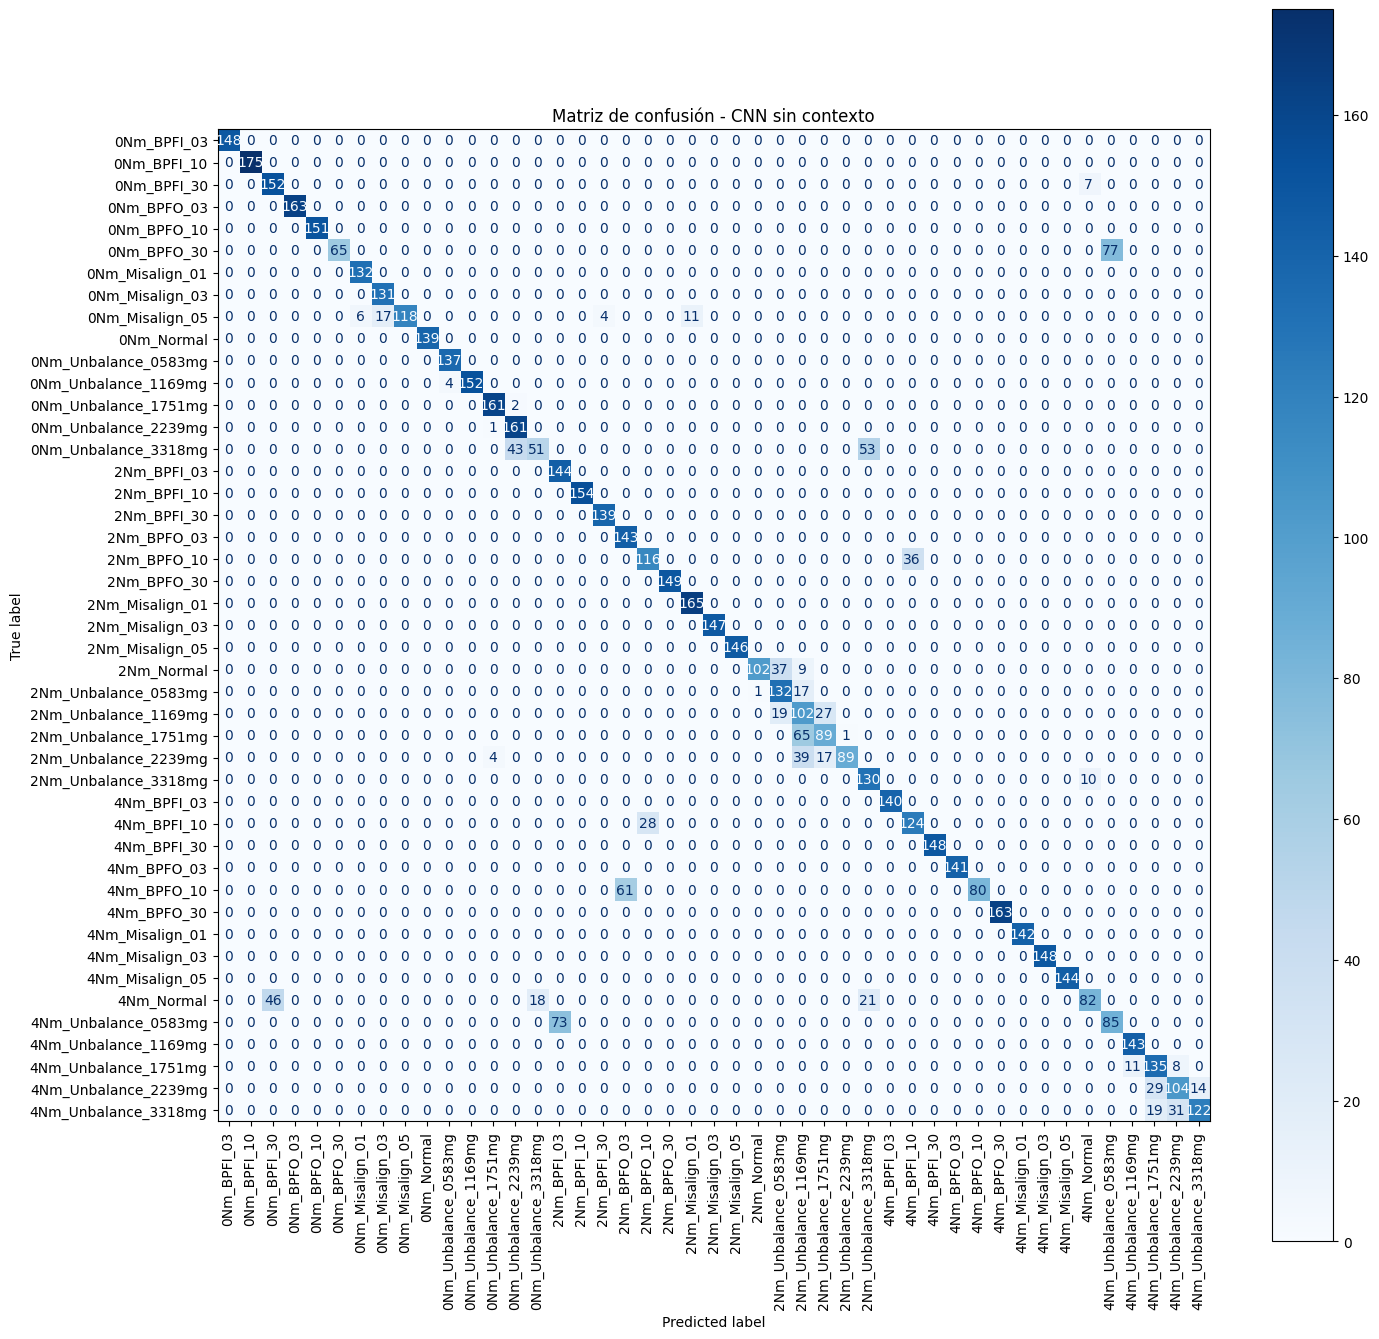

In [ ]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Cargar mejor modelo guardado
best_model = CNN_NoContext(num_classes).to(device)
best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model.eval()

all_labels, all_preds = [], []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = best_model(x_batch)
        preds = outputs.argmax(dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# =====================
# Calcular Cohen's Kappa
# =====================
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa (global): {kappa:.4f}")

# =====================
# Matriz de confusión
# =====================
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(16, 16))
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)
plt.title("Matriz de confusión - CNN sin contexto")
plt.show()
